<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_single_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Single Stock Trading

Tutorials to use OpenAI DRL to trade single stock in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-single-stock-trading-37d6d7c30aac
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues



## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: single stock trading for AAPL


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.

We use Apple Inc. stock: AAPL as an example throughout this article, because it is one of the most popular and profitable stocks.

<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-xjk7w6qh
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-xjk7w6qh
     |████████████████████████████████| 6.6MB 4.8MB/s 
     |████████████████████████████████| 1.6MB 36.2MB/s 
     |████████████████████████████████| 245kB 39.7MB/s 
     |████████████████████████████████| 110.5MB 47kB/s 
     |████████████████████████████████| 307kB 44.6MB/s 
     |████████████████████████████████| 12.4MB 23.1MB/s 
     |████████████████████████████████| 256kB 38.3MB/s 
     |████████████████████████████████| 583kB 45.0MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-7woxk6he/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-7woxk6he/pyfolio
     |████████████████████████████████| 5.5MB 38.8MB/s 
     |████████████████████████████████| 1.0MB 28.6MB/s 
     |████████████████████████████████| 


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4


<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE

'2020-09-30'

ticker_list is a list of stock tickers, in a single stock trading case, the list contains only 1 ticker

In [7]:
# Download and save the data in a pandas DataFrame:
data_df = YahooDownloader(start_date = config.START_DATE,
                          end_date = config.END_DATE,
                          ticker_list = ['AAPL']).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2956, 7)


In [8]:
data_df.shape

(2956, 7)

In [9]:
data_df.head()

,date,open,high,low,close,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200,AAPL
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1181608400,AAPL
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1289310400,AAPL
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,753048800,AAPL
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,673500800,AAPL


<a id='3'></a>
# Part 4. Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* FinRL uses a class **FeatureEngineer** to preprocess the data
* Add **technical indicators**. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc.


class FeatureEngineer:
Provides methods for preprocessing the stock price data

    Attributes
    ----------
        df: DataFrame
            data downloaded from Yahoo API
        feature_number : int
            number of features we used
        use_technical_indicator : boolean
            we technical indicator or not
        use_turbulence : boolean
            use turbulence index or not

    Methods
    -------
    preprocess_data()
        main method to do the feature engineering

<a id='3.1'></a>

## 4.1 Technical Indicators
* FinRL uses stockstats to calcualte technical indicators such as **Moving Average Convergence Divergence (MACD)**, **Relative Strength Index (RSI)**, **Average Directional Index (ADX)**, **Commodity Channel Index (CCI)** and other various indicators and stats.
* **stockstats**: supplies a wrapper StockDataFrame based on the **pandas.DataFrame** with inline stock statistics/indicators support.



In [10]:
## we store the stockstats technical indicator column names in config.py
tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
print(tech_indicator_list)

['macd', 'rsi_30', 'cci_30', 'dx_30']


In [11]:
## user can add more technical indicators
## check https://github.com/jealous/stockstats for different names
tech_indicator_list=tech_indicator_list+['kdjk','open_2_sma','boll','close_10.0_le_5_c','wr_10','dma','trix']
print(tech_indicator_list)

['macd', 'rsi_30', 'cci_30', 'dx_30', 'kdjk', 'open_2_sma', 'boll', 'close_10.0_le_5_c', 'wr_10', 'dma', 'trix']


<a id='3.2'></a>
## 4.2 Perform Feature Engineering

In [12]:
data_df = FeatureEngineer(data_df.copy(),
                          use_technical_indicator=True,
                          tech_indicator_list = tech_indicator_list,
                          use_turbulence=False,
                          user_defined_feature = True).preprocess_data()

Successfully added technical indicators
Successfully added user defined features


In [13]:
data_df.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,daily_return
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200,AAPL,0.000000,100.000000,66.666667,100.000000,-9.241443,3.067143,2.773207,1.0,227.724329,0.0,0.670733,0.042204
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1181608400,AAPL,0.002626,100.000000,66.666667,100.000000,-18.965140,3.197322,2.831728,2.0,138.412535,0.0,0.670733,0.042204
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1289310400,AAPL,0.001868,70.355256,46.810872,100.000000,-28.096875,3.377143,2.835344,3.0,146.360343,0.0,0.391302,-0.016494
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,753048800,AAPL,-0.000741,50.429273,-29.735567,43.608349,-38.958050,3.352857,2.821796,4.0,160.680401,0.0,0.195391,-0.021608
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,673500800,AAPL,-0.000087,60.227005,-9.052599,48.358256,-42.185416,3.254286,2.823996,5.0,148.640149,0.0,0.125123,0.018569


<a id='4'></a>
# Part 5. Build Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

<a id='4.1'></a>
## 5.1 Training & Trade data split
* Training: 2009-01-01 to 2018-12-31
* Trade: 2019-01-01 to 2020-09-30

In [14]:
train = data_split(data_df, start = config.START_DATE, end = config.START_TRADE_DATE)
trade = data_split(data_df, start = config.START_TRADE_DATE, end = config.END_DATE)
#train = data_split(data_df, start = '2009-01-01', end = '2019-01-01')
#trade = data_split(data_df, start = '2019-01-01', end = '2020-09-30')


In [15]:
## data normalization, this part is optional, have little impact
feaures_list = list(train.columns)
feaures_list.remove('date')
feaures_list.remove('tic')
feaures_list.remove('close')
print(feaures_list)
from sklearn import preprocessing
data_normaliser = preprocessing.StandardScaler()
train[feaures_list] = data_normaliser.fit_transform(train[feaures_list])
trade[feaures_list] = data_normaliser.transform(trade[feaures_list])

['open', 'high', 'low', 'volume', 'macd', 'rsi_30', 'cci_30', 'dx_30', 'kdjk', 'open_2_sma', 'boll', 'close_10.0_le_5_c', 'wr_10', 'dma', 'trix', 'daily_return']


<a id='4.2'></a>
## 5.2 User-defined Environment: a simulation environment class 

In [16]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class SingleStockEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (self.state_space,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital amount + close price + shares + technical indicators + other features
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim  + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])+ \
                      [self.data.open] + \
                      [self.data.high] + \
                      [self.data.low] +\
                      [self.data.daily_return] 
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        self.close_price_memory = [self.data.close]
        self.trades = 0
        self._seed()


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+self.stock_dim+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             (1- self.transaction_cost_pct)

            self.state[index+self.stock_dim+1] -= min(abs(action), self.state[index+self.stock_dim+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             self.transaction_cost_pct
            self.trades+=1
        else:
            pass

    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ self.transaction_cost_pct)

        self.state[index+self.stock_dim+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          self.transaction_cost_pct
        self.trades+=1
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            #plt.plot(self.asset_memory,'r')
            #plt.savefig('results/account_value_train.png')
            #plt.close()
            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            #df_total_value.to_csv('results/account_value_train.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            if df_total_value['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                    df_total_value['daily_return'].std()
              print("Sharpe: ",sharpe)
              print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('results/account_rewards_train.csv')
            
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print(actions)
            actions = actions * self.hmax
            self.actions_memory.append(actions)
            #actions = (actions.astype(int))
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    [self.data.close] + \
                    list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])+ \
                      [self.data.open] + \
                      [self.data.high] + \
                      [self.data.low] +\
                      [self.data.daily_return] 
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self.data.date)
            self.close_price_memory.append(self.data.close)

            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*self.reward_scaling



        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        #initiate state
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])+ \
                      [self.data.open] + \
                      [self.data.high] + \
                      [self.data.low] +\
                      [self.data.daily_return] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
    
    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory[:-1]
        close_price_list = self.close_price_memory[:-1]

        action_list = self.actions_memory
        df_actions = pd.DataFrame({'date':date_list,'actions':action_list,'close_price':close_price_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

<a id='4.3'></a>
## 5.3 Initialize Environment
* **stock dimension**: the number of unique stock tickers we use
* **hmax**: the maximum amount of shares to buy or sell
* **initial amount**: the amount of money we use to trade in the begining
* **transaction cost percentage**: a per share rate for every share trade
* **tech_indicator_list**: a list of technical indicator names (modified from config.py)

In [17]:
## we store the stockstats technical indicator column names in config.py
## check https://github.com/jealous/stockstats for different names
tech_indicator_list

['macd',
 'rsi_30',
 'cci_30',
 'dx_30',
 'kdjk',
 'open_2_sma',
 'boll',
 'close_10.0_le_5_c',
 'wr_10',
 'dma',
 'trix']

In [18]:
# the stock dimension is 1, because we only use the price data of AAPL.
len(train.tic.unique())

1

In [19]:
# account balance + close price + shares + technical indicators + open-high-low-price + 1 returns
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicator_list)*stock_dimension + 4*stock_dimension
print(state_space)


18


In [20]:
env_setup = EnvSetup(stock_dim = stock_dimension,
                     state_space = state_space,
                     hmax = 200,
                     initial_amount = 100000,
                     transaction_cost_pct = 0.001,
                     tech_indicator_list = tech_indicator_list)

In [21]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)

In [22]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,daily_return
0,2009-01-02,-1.578215,-1.566845,-1.576249,2.773207,1.618116,AAPL,-0.241386,4.683665,0.312711,4.127094,1.206457,-1.577762,-1.464083,-0.010711,0.357995,-0.244284,1.906911,2.445709
1,2009-01-05,-1.557496,-1.552355,-1.554610,2.890248,3.377073,AAPL,-0.235643,4.683665,0.312711,4.127094,1.086825,-1.567402,-1.459330,0.488327,-0.678000,-0.244284,1.906911,2.445709
2,2009-01-06,-1.549595,-1.549564,-1.555527,2.842576,3.811981,AAPL,-0.237302,1.552373,0.131576,4.127094,0.974475,-1.553091,-1.459036,0.987365,-0.585807,-0.244284,0.958661,-1.055377
3,2009-01-07,-1.561361,-1.562729,-1.561632,2.781153,1.646519,AAPL,-0.243006,-0.552353,-0.566723,1.011709,0.840848,-1.555024,-1.460137,1.486403,-0.419698,-0.244284,0.293837,-1.360408
4,2009-01-08,-1.565283,-1.560897,-1.562262,2.832797,1.325298,AAPL,-0.241577,0.482554,-0.378042,1.274120,0.801141,-1.562869,-1.459958,1.985441,-0.559362,-0.244284,0.055384,1.036004


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [23]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC



### Model 1: A2C

In [ ]:
## default hyperparameters in config file
config.A2C_PARAMS

{'ent_coef': 0.01,
 'learning_rate': 0.0007,
 'n_steps': 5,
 'timesteps': 20000,
 'verbose': 0}

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0007,
			  'verbose':0,
			  'timesteps':100000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), model_params = a2c_params_tuning)

==============Model Training===========
begin_total_asset:100000
end_total_asset:176934.7576968735
total_reward:76934.75769687351
total_cost:  5882.835153967686
total_trades:  2484
Sharpe:  0.46981434691347806
begin_total_asset:100000
end_total_asset:595867.5745766863
total_reward:495867.57457668625
total_cost:  4290.078180151586
total_trades:  2514
Sharpe:  0.8764031127847676
begin_total_asset:100000
end_total_asset:583671.8077524664
total_reward:483671.8077524664
total_cost:  5838.791503323599
total_trades:  2512
Sharpe:  0.8828870827729837
begin_total_asset:100000
end_total_asset:637429.0815745457
total_reward:537429.0815745457
total_cost:  3895.962820358061
total_trades:  2514
Sharpe:  0.8993083850920852
begin_total_asset:100000
end_total_asset:766699.1715777694
total_reward:666699.1715777694
total_cost:  1336.049787657923
total_trades:  2515
Sharpe:  0.9528759647152936
begin_total_asset:100000
end_total_asset:882677.1870489779
total_reward:782677.1870489779
total_cost:  785.382441

### Model 2: DDPG

In [ ]:
## default hyperparameters in config file
config.DDPG_PARAMS

{'batch_size': 128, 'buffer_size': 50000, 'timesteps': 20000, 'verbose': 0}

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ddpg_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':100000, 
			               'verbose':0,
			               'timesteps':50000}
model_ddpg = agent.train_DDPG(model_name = "DDPG_{}".format(now), model_params = ddpg_params_tuning)

==============Model Training===========
Instructions for updating:
Use keras.layers.Dense instead.





begin_total_asset:100000
end_total_asset:99995.7058569457
total_reward:-4.294143054299639
total_cost:  0.17149700678428698
total_trades:  10
Sharpe:  -0.4393937514363672
begin_total_asset:100000
end_total_asset:125223.8481070335
total_reward:25223.848107033496
total_cost:  693.701142432137
total_trades:  1159
Sharpe:  0.22317075597890754
begin_total_asset:100000
end_total_asset:78872.9656911464
total_reward:-21127.034308853603
total_cost:  354.44841880019516
total_trades:  270
Sharpe:  -0.31473719368550507
begin_total_asset:100000
end_total_asset:101105.50020441337
total_reward:1105.5002044133726
total_cost:  158.41803119077085
total_trades:  523
Sharpe:  0.05295084331155536
begin_total_asset:100000
end_total_asset:92841.32190924165
total_reward:-7158.678090758345
total_cost:  285.19241356424914
total_trades:  441
Sharpe:  -0.04400567053352091
begin_total_asset:100000
end_total_asset

### Model 3: PPO

In [ ]:
config.PPO_PARAMS

{'ent_coef': 0.01,
 'learning_rate': 0.00025,
 'n_steps': 128,
 'nminibatches': 4,
 'timesteps': 20000,
 'verbose': 0}

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ppo_params_tuning = {'n_steps':128, 
                     'nminibatches': 4,
			               'ent_coef':0.005, 
			               'learning_rate':0.00025,
			              'verbose':0,
			              'timesteps':50000}
model_ppo = agent.train_PPO(model_name = "PPO_{}".format(now), model_params = ppo_params_tuning)

==============Model Training===========




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




begin_total_asset:100000
end_total_asset:467641.36933949846
total_reward:367641.36933949846
total_cost:  6334.431322515711
total_trades:  2512
Sharpe:  0.8257905133964245

begin_total_asset:100000
end_total_asset:598301.9358692836
total_reward:498301.9358692836
total_cost:  6714.914704657209
total_trades:  2514
Sharpe:  0.9104137553610742
begin_total_asset:100000
end_total_asset:487324.45261743915
total_reward:387324.45261743915
total_cost:  6694.683756348197
total_trades:  2513
Sharpe:  0.8778200252832747
begin_total_asset:100000
end_total_asset:376587.1472550176
total_reward:276587.1472550176
total_cost:  6498.996226416659
total_trades:  2500
Sharpe:  0.9265883206757147
begin_total_asset:100000
end_total_asset:

### Model 4: TD3

In [24]:
## default hyperparameters in config file
config.TD3_PARAMS

{'batch_size': 128,
 'buffer_size': 50000,
 'learning_rate': 0.0001,
 'timesteps': 20000,
 'verbose': 0}

In [25]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
td3_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':200000, 
                     'learning_rate': 0.0002,
			               'verbose':0,
			               'timesteps':50000}
model_td3 = agent.train_TD3(model_name = "TD3_{}".format(now), model_params = td3_params_tuning)

==============Model Training===========




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




begin_total_asset:100000
end_total_asset:783194.916711496
total_reward:683194.916711496
total_cost:  127.39982264986166
total_trades:  2513
Sharpe:  0.9552403851207222

begin_total_asset:100000
end_total_asset:1066121.2912669356
total_reward:966121.2912669356
total_cost:  99.89596228181924
total_trades:  2515
Sharpe:  1.0660874653722894
begin_total_asset:100000
end_total_asset:1063729.743694697
total_reward:963729.743694697
total_cost:  99.89613513119843
total_trades:  2515
Sharpe:  1.0653953427195073
begin_total_asset:100000
end_total_asset:1066518.2358544066
total_reward:966518.2358544066
total_cost:  99.89629214983829
total_trades:  2515
Sharpe:  1.06

### Model 5: SAC

In [ ]:
## default hyperparameters in config file
config.SAC_PARAMS

{'batch_size': 64,
 'buffer_size': 100000,
 'ent_coef': 'auto_0.1',
 'learning_rate': 0.0001,
 'learning_starts': 100,
 'timesteps': 50000,
 'verbose': 0}

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
sac_params_tuning={
  'batch_size': 64,
 'buffer_size': 100000,
  'ent_coef':'auto_0.1',
 'learning_rate': 0.0001,
 'learning_starts':200,
 'timesteps': 50000,
 'verbose': 0}
model_sac = agent.train_SAC(model_name = "SAC_{}".format(now), model_params = sac_params_tuning)

==============Model Training===========

begin_total_asset:100000
end_total_asset:628197.7965312647
total_reward:528197.7965312647
total_cost:  161.17551531590826
total_trades:  2493
Sharpe:  0.8786969593304516
begin_total_asset:100000
end_total_asset:1077672.4272528668
total_reward:977672.4272528668
total_cost:  99.89875688362122
total_trades:  2515
Sharpe:  1.069666896575114
begin_total_asset:100000
end_total_asset:1077672.4272528668
total_reward:977672.4272528668
total_cost:  99.89875688362122
total_trades:  2515
Sharpe:  1.069666896575114
begin_total_asset:100000
end_total_asset:1077672.4272528668
total_reward:977672.4272528668
total_cost:  99.89875688362122
total_trades:  2515
Sharpe:  1.069666896575114
begin_total_asset:100000
end_total_asset:1077672.4272528668
total_reward:977672.4272528668
total_cost:  99.89875688362122
total_trades:  2515
Sharpe:  1.069666896575114
begin_total_asset:100000
end_total_asset:1077672.4272528668
total_reward:977672.4272528668
total_cost:  99.898756

### Trading
* we use the environment class we initialized at 5.3 to create a stock trading environment
* Assume that we have $100,000 initial capital at 2019-01-01. 
* We use the trained model of PPO to trade AAPL.

In [26]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,kdjk,open_2_sma,boll,close_10.0_le_5_c,wr_10,dma,trix,daily_return
0,2019-01-02,1.259187,1.311140,1.273863,38.249401,-0.796071,AAPL,-4.623404,-1.879233,-1.130976,0.936711,1.584543,1.296077,1.535902,-0.509749,-1.478527,-5.464510,-2.953890,-0.003511
1,2019-01-03,1.042136,1.052042,1.028504,34.439476,0.080554,AAPL,-5.020681,-2.419562,-1.918796,1.654691,1.409904,1.151332,1.493971,-0.509749,-0.930227,-5.623870,-2.960046,-6.012728
2,2019-01-04,1.053078,1.107887,1.064615,35.909672,-0.447708,AAPL,-5.020959,-2.056112,-1.570256,1.202432,1.418700,1.048269,1.466007,-0.509749,-1.218098,-5.592501,-2.968936,2.474654
3,2019-01-07,1.136039,1.113412,1.106746,35.829746,-0.509560,AAPL,-4.980654,-2.067081,-1.415251,1.157374,1.417011,1.095224,1.439656,-0.509749,-1.211709,-5.483187,-2.973126,-0.204331
4,2019-01-08,1.153148,1.172415,1.159309,36.512772,-0.731694,AAPL,-4.775895,-1.900079,-1.162272,0.676332,1.480427,1.145263,1.422207,-0.509749,-1.394265,-5.247375,-2.945117,1.065455


In [27]:
# create trading env
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                                    env_class = SingleStockEnv) 

In [28]:
## make a prediction and get the account value change
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model_td3,
                                           test_data = trade,
                                           test_env = env_trade,
                                           test_obs = obs_trade)

begin_total_asset:100000
end_total_asset:308768.3018266945
total_reward:208768.30182669451
total_cost:  99.89708306503296
total_trades:  439
Sharpe:  1.9188345294206783


<a id='6'></a>
# Part 7: Backtesting Performance
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [29]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  104.80443553947256
sharpe ratio:  1.9188345294206783
Annual return          0.907331
Cumulative returns     2.087683
Annual volatility      0.374136
Sharpe ratio           1.918835
Calmar ratio           2.887121
Stability              0.909127
Max drawdown          -0.314268
Omega ratio            1.442243
Sortino ratio          2.903654
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.049744
Daily value at risk   -0.044288
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to AAPL itself buy-and-hold===========
annual return:  104.80443553947256
sharpe ratio:  1.9188345294206783
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)


Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,91.014%
Cumulative returns,208.768%
Annual volatility,37.414%
Sharpe ratio,1.92
Calmar ratio,2.90
Stability,0.91
Max drawdown,-31.427%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.43,2020-02-12,2020-03-23,2020-06-03,81
1,20.38,2020-09-01,2020-09-18,NaT,NaN
2,17.84,2019-05-03,2019-06-03,2019-07-31,64
3,9.25,2019-07-31,2019-08-05,2019-08-21,16
4,5.84,2020-07-20,2020-07-24,2020-07-31,10


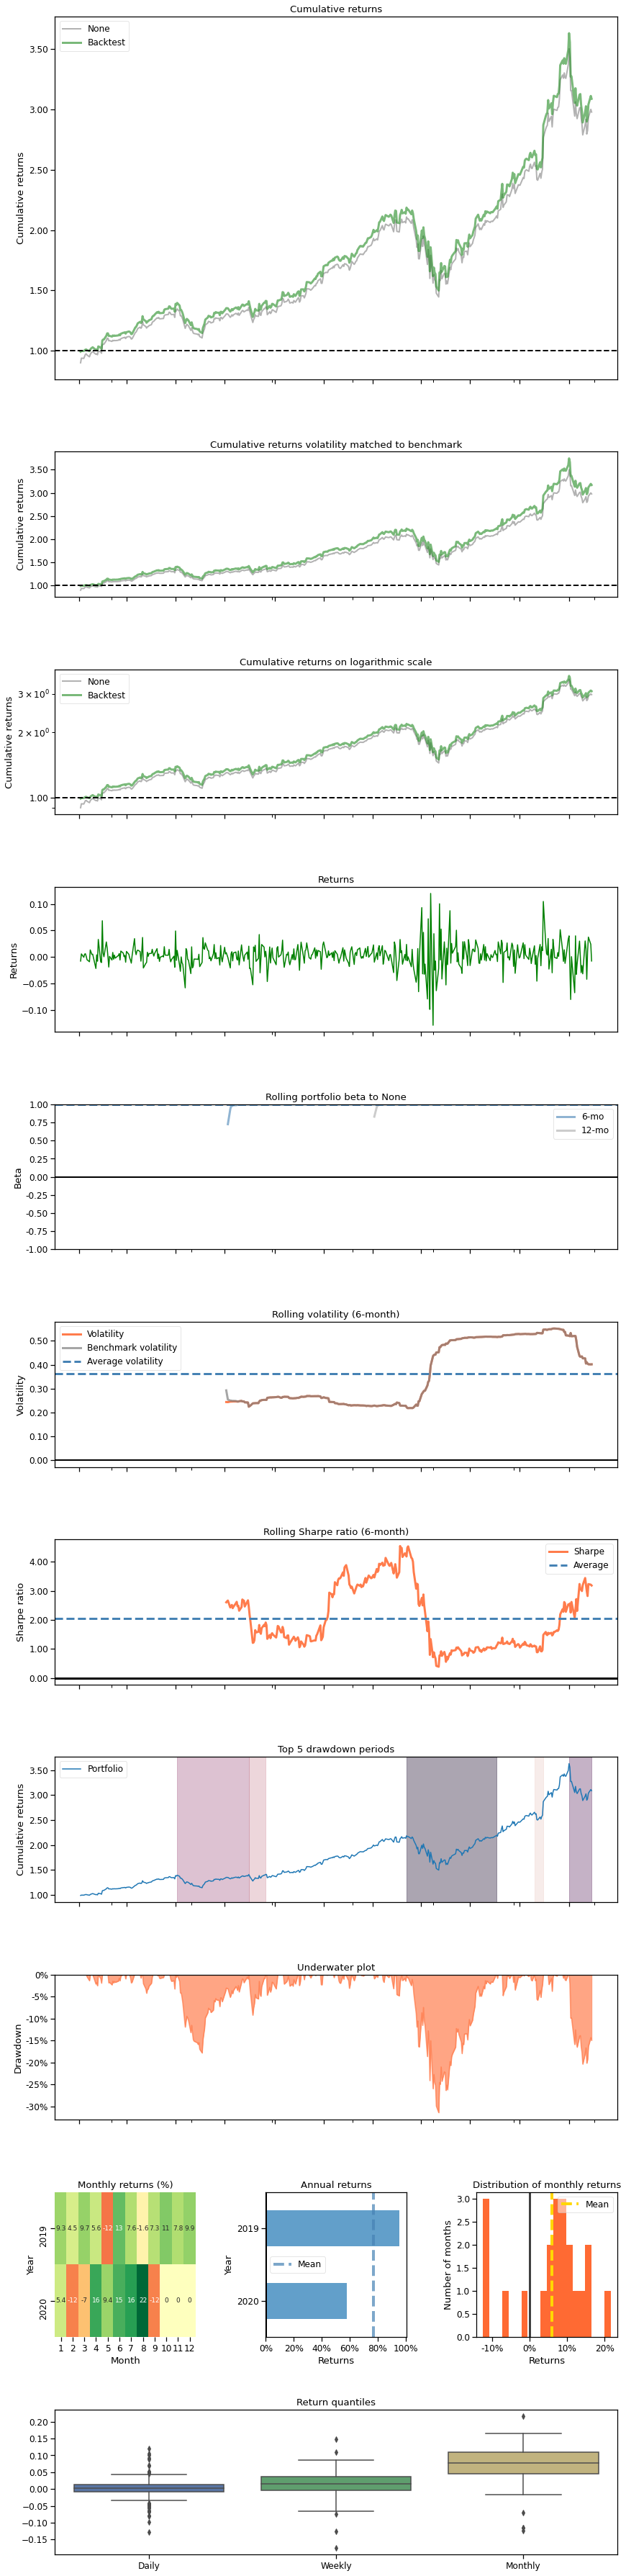

In [30]:
print("==============Compare to AAPL itself buy-and-hold===========")
%matplotlib inline
BackTestPlot(account_value=df_account_value, baseline_ticker = 'AAPL')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [31]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('AAPL')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)
Annual return          0.868103
Cumulative returns     1.977654
Annual volatility      0.384009
Sharpe ratio           1.825350
Calmar ratio           2.762260
Stability              0.909223
Max drawdown          -0.314273
Omega ratio            1.416301
Sortino ratio          2.709220
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.067808
Daily value at risk   -0.045599
Alpha                  0.000000
Beta                   1.000000
dtype: float64


In [32]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^GSPC')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)
Annual return          0.176845
Cumulative returns     0.328857
Annual volatility      0.270644
Sharpe ratio           0.739474
Calmar ratio           0.521283
Stability              0.339596
Max drawdown          -0.339250
Omega ratio            1.174869
Sortino ratio          1.015508
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.659621
Daily value at risk   -0.033304
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.4'></a>
## 7.4 Compare to Stock Market Index

==============Compare to S&P 500===========
annual return:  104.80443553947256
sharpe ratio:  1.9188345294206783
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)


Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,91.014%
Cumulative returns,208.768%
Annual volatility,37.414%
Sharpe ratio,1.92
Calmar ratio,2.90
Stability,0.91
Max drawdown,-31.427%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.43,2020-02-12,2020-03-23,2020-06-03,81
1,20.38,2020-09-01,2020-09-18,NaT,NaN
2,17.84,2019-05-03,2019-06-03,2019-07-31,64
3,9.25,2019-07-31,2019-08-05,2019-08-21,16
4,5.84,2020-07-20,2020-07-24,2020-07-31,10


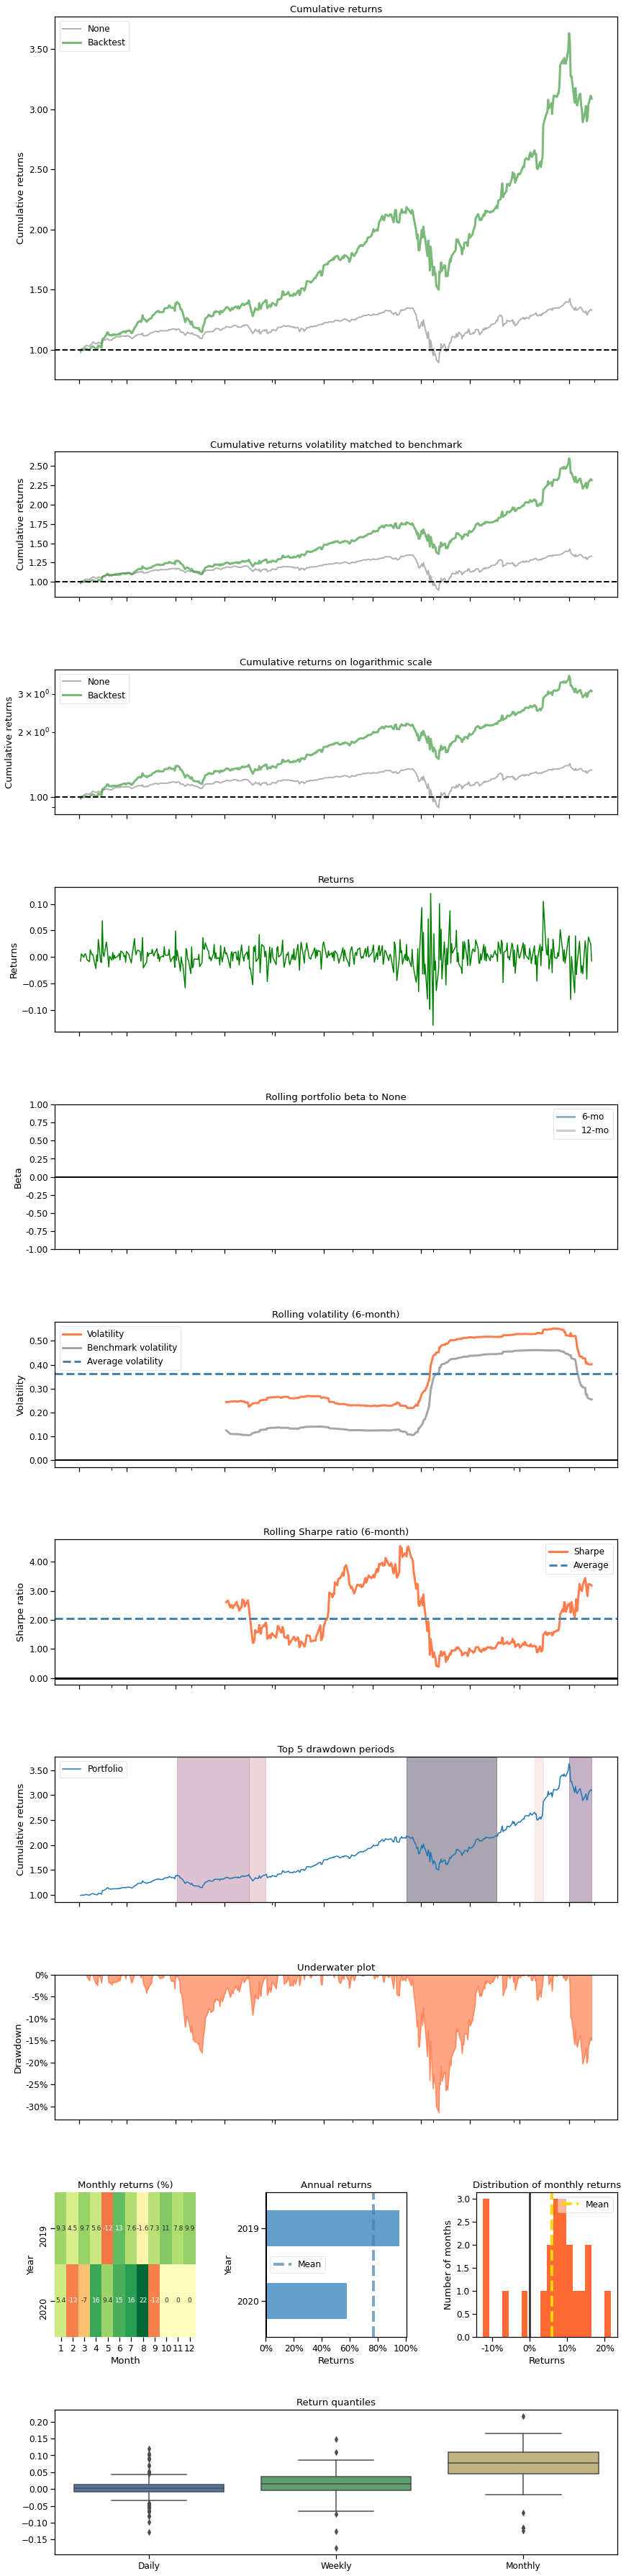

In [33]:
print("==============Compare to S&P 500===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, baseline_ticker = '^GSPC')